# Objetivo

Crearemos un modelo utilizando características avanzadas de econometría para tratar de estimar, en tiempo real, como será el indice de inflación del CPI (consumer price index) de Brasil (IPA). Esta medida no solo es la mas utilizada para medir la inflación en Brasil, si no que también es utilizada para la inflación objetivo para políticas del banco central.

Este problema es interesante porque Brasil es una economía emergente, que no se regirá como otras economías ya establecidas y con comportamientos menos turbulentos.

# Importar Dependencias

In [ ]:
import os

# Manejo de los datos
import pandas as pd
import numpy as np

# Utilidades, modelo y métricas
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Visualización
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt

from pprint import pprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Cruso-ApsFinancieras/semana2/'

In [ ]:
pio.templates.default = "plotly_white"

# Función de visualización auxiliar

In [ ]:
# Función para visualizar de mejor manera nustro modelo
def plot_model_evaluation(real_train, predecido_train, real_test, predecido_test, plot_title):
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['Conjunto de entrenamiento', 'Conjunto de prueba'],
    )

    fig.add_trace(
        go.Scatter(
            x=real_train,
            y=predecido_train,
            mode='markers',
        ),
        row=1, col=1
    )

    fig.add_shape(
        type='line',
        x0=np.min(predecido_train), y0=np.min(predecido_train),
        x1=np.max(predecido_train), y1=np.max(predecido_train),
        line=dict(dash='dot')
    )

    fig.add_trace(
        go.Scatter(x=real_test, y=predecido_test, mode='markers'),
        row=1, col=2
    )

    fig.add_shape(
        type='line',
        x0=np.min(predecido_test), y0=np.min(predecido_test),
        x1=np.max(predecido_test), y1=np.max(predecido_test),
        line=dict(dash='dot'),
        row=1, col=2
    )

    fig.update_layout(
        showlegend=False,
        title_text=plot_title
    )

    fig.update_xaxes(title_text='Datos reales', row=1, col=1)
    fig.update_xaxes(title_text='Datos reales', row=1, col=2)
    fig.update_yaxes(title_text='Datos predecidos', row=1, col=1)
    fig.update_yaxes(title_text='Datos predecidos', row=1, col=2)

    return fig

# Carga de datos

In [ ]:
data = pd.read_csv(path + 'Brazil.csv', sep=';')

In [ ]:
data.info()

# Algunas de las características con las que trabajaremos:

Precios y Monetarios
1. Brazil CPI IPCA (Extended National Consumer Price Index)
2. FGV Brazil General Prices IGP-M 
3. FGV Brazil General Prices IGP-DI 
4. FGV Brazil General Prices IGP-10 
5. Brazil CPI IPCA-15 
55. Brazil Monetary Base 
56. Brazil Money Supply M1 Brazil 
57. Brazil Money Supply M2 Brazil 
58. Brazil Money Supply M3 Brazil
59. Brazil Money Supply M4 Brazil

Empleo
14. IBGE Brazil Unemployment Rate 
15. Brazil Unemployment Statistic Male 
16. Brazil Unemployment Statistic Total
17. IMF Brazil Unemployment Rate
18. CNI Brazil Manufacturing Industry Employment
19. Brazil Industry Working Hours 

Tipos de Cambio y Finanzas
22. USD-BRL X-RATE 
23. USD-BRL X-RATE Tourism 
24. EUR-BRL X-RATE 
25. BRAZIL IBOVESPA INDEX
26. Brazil Savings Accounts Deposits
27. Brazil Total Savings Deposits
28. Brazil BNDES Long Term Interest Rate
29. Brazil Selic Target Rate
30. Brazil Cetip DI Interbank Deposits

Relacionados a Gobierno y Transacciones Internacionales
32. Brazil National Treasury Revenue Total
33. Brazil Social Contribution over Net Profit Tax Income
34. Brazil PIS & PASEP Tax Income
35. Brazil Central Government Net Revenue
36. Brazil Central Government Revenue from the Central Bank
37. Brazil Central Government Total Expenditures
38. Brazil National Treasury Gross Revenue
39. Brazil Importing Tax Income
40. BNDES Brazil Income Taxes
41. Brazil National Treasury Revenue from Industrialized Products
42. Brazil National Treasury Revenues from Other Taxes
43. Brazil Central Government Revenue from the Social Security
44. Brazil National Treasury Revenue from Import Tax
45. Brazil Current Account
46. Brazil Trade Balance FOB
47. Brazil Public Net Fiscal Debt as a percentage of GDP
48. Brazil Public Net Fiscal Debt
49. Brazilian Federal Government Domestic Debt
50. Brazil Public Net Government & Central Bank Domestic Debt
51. Brazilian States Debt Total Consolidated Net Debt
52. Brazilian States Debt to Foreigners
53. Brazilian Cities Debt
54. Brazilian Cities Debt to Foreigners





- ¿Qué pasa al buscar por valores nulos?

In [ ]:
data.isnull().sum().sum()

In [ ]:
data.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [ ]:
# Ver que columnas hay en nuestro DataFrame
columns_by_type = {
    'float64':      data.select_dtypes('float64').columns,
    'int64':        data.select_dtypes('int64').columns,
    'object':       data.select_dtypes('object').columns
}

In [ ]:
pprint(columns_by_type)

{'float64': Index(['Brazil CPI IPCA MoM', 'FGV Brazil General Prices IGP-',
       'FGV Brazil General Prices IGP-.1', 'FGV Brazil General Prices IGP-.2',
       'FGV Brazil General Prices IGP-.3', 'Brazil CPI IPCA Median Market',
       'Brazil Total Electricity Consu', 'BofA Merrill Lynch Economic Co',
       'CNI Brazil Manufacture Industr', 'CNI Brazil Manufacture Industr.1',
       'Brazil Industrial Production S', 'Brazil Industrial Production A',
       'IBGE Brazil Unemployment Rate', 'IMF Brazil Unemployment Rate i',
       'CNI Brazil Manufacture Industr.2', 'Brazil Industry Working Hours',
       'Brazil Average Real Income', 'USD-BRL X-RATE', 'USD-BRL X-RATE.1',
       'EUR-BRL X-RATE', 'BRAZIL IBOVESPA INDEX',
       'Brazil Savings Accounts Deposi', 'Brazil BNDES Long Term Interes',
       'Brazil Selic Target Rate', 'Brazil Cetip DI Interbank Depo',
       'Brazil National Treasury Reven', 'Brazil Social Contribution ove',
       'Brazil PIS & PASEP Tax Income', 'Brazil 

In [ ]:
# ¿Que hacer con la columna 'Brazil CPI IPCA Median Market'?
X = data.drop(columns = ['Brazil CPI IPCA MoM', 'Unnamed: 0', 'Brazil CPI IPCA Median Market'])
y = data['Brazil CPI IPCA MoM']

In [ ]:
corr_df = X.corr()
fig = px.imshow(corr_df,
          labels=dict(color="Correlación"),
          x=corr_df.index,
          y=corr_df.columns,
          range_color=[-1, 1],
          color_continuous_scale="oxy"
          )
fig.show()

In [ ]:
correlated_features = set()
for i in range(len(corr_df.columns)):
    for j in range(i):
        if abs(corr_df.iloc[i, j]) > 0.8:
            colname = corr_df.columns[i]
            correlated_features.add(colname)
len(correlated_features)

42

In [ ]:
X

In [ ]:
correlated_features

{'BNDES Brazil Income Taxes UmBr',
 'Brazil Central Government Net',
 'Brazil Central Government Reve',
 'Brazil Central Government Reve.1',
 'Brazil Central Government Tota',
 'Brazil Cetip DI Interbank Depo',
 'Brazil Minimum Wage',
 'Brazil Monetary Base',
 'Brazil Money Supply M4 Brazil',
 'Brazil National Treasury Gross',
 'Brazil National Treasury Reven',
 'Brazil National Treasury Reven.2',
 'Brazil Public Net Fiscal Debt.1',
 'Brazil Unemployment Statistic',
 'Brazil Unemployment Statistic.1',
 'Brazilian Cities Debt to Forei',
 'Brazilian Cities Debt to Forei.1',
 'Brazilian Federal Government D',
 'CNI Brazil Manufacture Industr.2',
 'FGV Brazil General Prices IGP-.1',
 'FGV Brazil General Prices IGP-.2',
 'FGV Brazil General Prices IGP-.3',
 'IMF Brazil Unemployment Rate i',
 'X5t.1',
 'X5t.10',
 'X5t.11',
 'X5t.12',
 'X5t.13',
 'X5t.2',
 'X5t.3',
 'X5t.4',
 'X5t.5',
 'X5t.6',
 'X5t.7',
 'X5t.8',
 'X5t.9',
 'fmean',
 'fmean2',
 'fmed2',
 'lfmean',
 'lfmean2',
 'lfmed2'}

In [ ]:
X = X.drop(columns = correlated_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=1)

In [ ]:
X_train.shape

(124, 48)

In [ ]:
X_test.shape

(32, 48)

# Regresión lineal

In [ ]:
model_lr = LinearRegression()
linear_reg = model_lr.fit(X_train, y_train)
linear_reg.score(X_test, y_test)

0.8456372577833787

In [ ]:
y_pred_train_lr = model_lr.predict(X_train)
y_pred_test_lr = model_lr.predict(X_test)

In [ ]:
print(
    f"R2 train: {r2_score(y_train, y_pred_train_lr)}",
    f"R2 test: {r2_score(y_test, y_pred_test_lr)}",
    "",
    f"MSE train: {mean_squared_error(y_train, y_pred_train_lr)}",
    f"MSE test: {mean_squared_error(y_test, y_pred_test_lr)}",
    "",
    f"MAE train: {mean_absolute_error(y_train, y_pred_train_lr)}",
    f"MAE test: {mean_absolute_error(y_test, y_pred_test_lr)}",
    sep = '\n'
)

R2 train: 0.9610296209828519
R2 test: 0.8456372577833787

MSE train: 0.0037761942438463043
MSE test: 0.014244771730691039

MAE train: 0.04574947788004152
MAE test: 0.10158776954260365


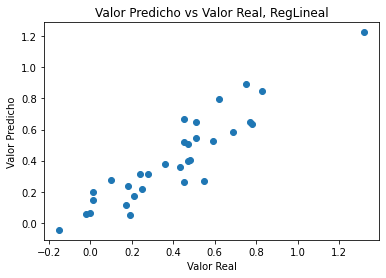

In [ ]:
# Primer aproximación a visualizar
plt.scatter(y_test, y_pred_test_lr)
plt.title('Valor Predicho vs Valor Real, RegLineal')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.show()

In [ ]:
plot_model_evaluation(y_train, y_pred_train_lr, y_test, y_pred_test_lr, "Regresión lineal")

# Regresión Ridge (con Penalización)

In [ ]:
model_rid1 = Ridge(alpha=1)
ridge_reg1 = model_rid1.fit(X_train, y_train)
ridge_reg1.score(X_test, y_test)

0.743361885753737

In [ ]:
y_pred_train_rr1 = model_rid1.predict(X_train)
y_pred_test_rr1 = model_rid1.predict(X_test)

In [ ]:
print(
    f"R2 train: {r2_score(y_train, y_pred_train_rr1)}",
    f"R2 test: {r2_score(y_test, y_pred_test_rr1)}",
    "",
    f"MSE train: {mean_squared_error(y_train, y_pred_train_rr1)}",
    f"MSE test: {mean_squared_error(y_test, y_pred_test_rr1)}",
    "",
    f"MAE train: {mean_absolute_error(y_train, y_pred_train_rr1)}",
    f"MAE test: {mean_absolute_error(y_test, y_pred_test_rr1)}",
    sep = '\n'
)

R2 train: 0.9348739053762252
R2 test: 0.743361885753737

MSE train: 0.006310659271090824
MSE test: 0.023682860917972122

MAE train: 0.05692204469704924
MAE test: 0.11343608907159587


In [ ]:
plot_model_evaluation(y_train, y_pred_train_rr1, y_test, y_pred_test_rr1, "Regresión Ridge, a=1")

$\alpha$ = 10

In [ ]:
model_rid10 = Ridge(alpha=10)
ridge_reg10 = model_rid10.fit(X_train, y_train)
ridge_reg10.score(X_test, y_test)

0.47567108525739443

In [ ]:
y_pred_train_rr10 = model_rid10.predict(X_train)
y_pred_test_rr10 = model_rid10.predict(X_test)

In [ ]:
print(
    f"R2 train: {r2_score(y_train, y_pred_train_rr10)}",
    f"R2 test: {r2_score(y_test, y_pred_test_rr10)}",
    "",
    f"MSE train: {mean_squared_error(y_train, y_pred_train_rr10)}",
    f"MSE test: {mean_squared_error(y_test, y_pred_test_rr10)}",
    "",
    f"MAE train: {mean_absolute_error(y_train, y_pred_train_rr10)}",
    f"MAE test: {mean_absolute_error(y_test, y_pred_test_rr10)}",
    sep = '\n'
)

R2 train: 0.8381775358239006
R2 test: 0.47567108525739443

MSE train: 0.015680449437710697
MSE test: 0.04838567645959549

MAE train: 0.0951288711515983
MAE test: 0.17181335678450285


In [ ]:
plot_model_evaluation(y_train, y_pred_train_rr10, y_test, y_pred_test_rr10, "Regresión Ridge, a=10")

¿Que pasa si hacemos Ridge sin deshacernos de las correlacionadas?

In [ ]:
model_lr = LinearRegression()
linear_reg = model_lr.fit(X_train, y_train)
linear_reg.score(X_test, y_test)

In [34]:
model_lr.coef_

array([ 3.34591792e-02,  4.02072554e-06, -4.36416168e-05, -3.80344920e-03,
        3.85087292e-04, -2.74242253e-03,  2.82571081e-04, -4.73944020e-04,
       -4.82639874e-02, -6.09095998e-03,  1.11810234e-06,  1.26355941e-03,
        6.56486212e-02,  8.97088480e-02,  7.14632333e-06,  1.98370809e-02,
       -6.54992007e-06,  3.34149978e-02, -5.05901674e-03, -8.66881606e-05,
        6.64231056e-04, -3.59396442e-04,  6.16031681e-02, -7.79364954e-02,
       -1.18846012e-05, -1.06916630e-06, -8.16205905e-02,  2.34596506e-02,
        8.50042248e-02, -2.29551868e-03,  3.27472742e-04, -1.96558179e-03,
        1.63639866e-03,  1.09014601e+00,  2.97696764e-02,  1.02229564e-01,
       -6.19870673e-02,  3.46168097e-01, -2.82888692e-01, -1.54665049e-01,
        3.90504774e-01, -3.50148488e-01,  1.69389769e-01, -2.65777854e-01,
        2.33097552e-01, -5.98927306e-01,  5.07098742e-01, -3.23241315e-01])

In [35]:
model_lr.feature_names_in_

array(['FGV Brazil General Prices IGP-', 'Brazil Total Electricity Consu',
       'Brazil Industrial Electricity', 'BofA Merrill Lynch Economic Co',
       'CNI Brazil Manufacture Industr',
       'CNI Brazil Manufacture Industr.1',
       'Brazil Industrial Production S', 'Brazil Industrial Production A',
       'IBGE Brazil Unemployment Rate', 'Brazil Industry Working Hours',
       'Brazil Average Real Income', 'USD-BRL X-RATE', 'USD-BRL X-RATE.1',
       'EUR-BRL X-RATE', 'BRAZIL IBOVESPA INDEX',
       'Brazil Savings Accounts Deposi', 'Brazil Total Savings Deposits',
       'Brazil BNDES Long Term Interes', 'Brazil Selic Target Rate',
       'Brazil Social Contribution ove', 'Brazil PIS & PASEP Tax Income',
       'Brazil Importing Tax Income No',
       'Brazil National Treasury Reven.1',
       'Brazil National Treasury Reven.3',
       'Brazil Current Account Monthly', 'Brazil Trade Balance FOB Balan',
       'Brazil Public Net Fiscal Debt', 'Brazil Public Net Government &',
 

In [36]:
model_lr.intercept_

0.21627312685768307